# PaddleOCR Quickstart

This notebook demonstrates running PaddleOCR on an image and visualizing its quadrilateral detections.

In [1]:

from pathlib import Path
from collections.abc import Mapping
from numbers import Number

import cv2
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
from PIL import Image, ImageDraw, ImageFont
from paddleocr import PPStructureV3
import numpy as np

PROJECT_ROOT = Path("/Users/mattcarroll/code/memoir").resolve()
NOTEBOOK_DIR = PROJECT_ROOT / "notebooks"

DEFAULT_DIRS = [
    Path("../testing/test_images"),
]

MAX_LONG_SIDE = 1080  # cap longest edge at ~HD resolution

print("Configured image directories:")
for configured in DEFAULT_DIRS:
    resolved = (configured if configured.is_absolute() else (NOTEBOOK_DIR / configured).resolve())
    status = "" if resolved.exists() else " (missing)"
    print(f" - {resolved}{status}")


/Users/mattcarroll/code/memoir/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Default image path: /Users/mattcarroll/code/memoir/logs/benchmark_output/original_2025-10-13_18-15-10-019586.png


In [2]:
# Initialize PaddleOCR model once
ocr = PaddleOCR(
    lang='en',
    use_textline_orientation=True,  # new in 3.x; replaces use_angle_cls
    det_limit_type='max',           # enforce a hard size limit on detector input
    det_limit_side_len=1536,        # detector won’t process larger than this
    rec_batch_num=2                 # smaller batches → lower peak memory
)
print("Model ready.")

/var/folders/j7/60_wtgqj1fdgxycmsdsn5zgc0000gn/T/ipykernel_19479/4244390136.py:2: DeprecationWarning: The parameter `det_limit_type` has been deprecated and will be removed in the future. Please use `text_det_limit_type` instead.
  ocr = PaddleOCR(
/var/folders/j7/60_wtgqj1fdgxycmsdsn5zgc0000gn/T/ipykernel_19479/4244390136.py:2: DeprecationWarning: The parameter `det_limit_side_len` has been deprecated and will be removed in the future. Please use `text_det_limit_side_len` instead.
  ocr = PaddleOCR(
/var/folders/j7/60_wtgqj1fdgxycmsdsn5zgc0000gn/T/ipykernel_19479/4244390136.py:2: DeprecationWarning: The parameter `rec_batch_num` has been deprecated and will be removed in the future. Please use `text_recognition_batch_size` instead.
  ocr = PaddleOCR(
/Users/mattcarroll/code/memoir/venv/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and inst

Model ready.


Text(0.5, 1.0, 'Original Image')

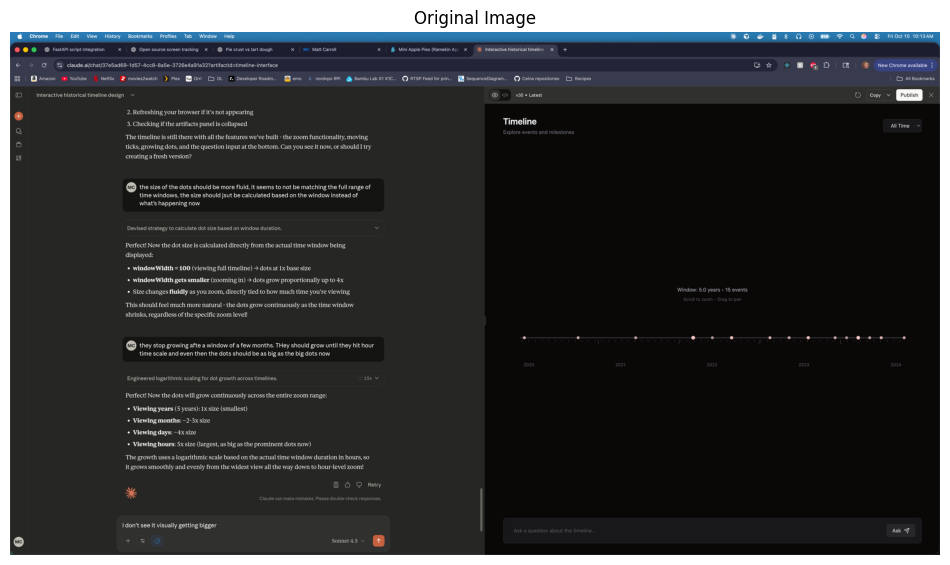

In [3]:

SUPPORTED_EXTENSIONS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp", ".webp"}

def resolve_dir(path: Path) -> Path:
    if path.is_absolute():
        return path
    candidate = (NOTEBOOK_DIR / path).resolve()
    if candidate.exists():
        return candidate
    return (PROJECT_ROOT / path).resolve()

def iter_image_paths(directories, extensions=SUPPORTED_EXTENSIONS):
    seen = set()
    for directory in directories:
        resolved = resolve_dir(directory)
        if not resolved.exists():
            print(f"Skipping missing directory: {resolved}")
            continue
        for child in sorted(resolved.iterdir()):
            if child.is_file() and child.suffix.lower() in extensions:
                if child not in seen:
                    seen.add(child)
                    yield child

def load_and_prepare_image(image_path: Path, max_long_side: int = MAX_LONG_SIDE):
    image_bgr = cv2.imread(str(image_path))
    if image_bgr is None:
        raise ValueError(f"Unable to read image: {image_path}")
    original_shape = image_bgr.shape[:2]  # (H, W)
    max_dim = max(original_shape)
    scale = 1.0
    if max_dim > max_long_side:
        scale = max_long_side / float(max_dim)
        new_size = (
            max(1, int(round(original_shape[1] * scale))),
            max(1, int(round(original_shape[0] * scale))),
        )
        image_bgr = cv2.resize(image_bgr, new_size, interpolation=cv2.INTER_AREA)
    resized_shape = image_bgr.shape[:2]
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return {
        "bgr": image_bgr,
        "rgb": image_rgb,
        "original_shape": original_shape,
        "resized_shape": resized_shape,
        "scale": scale,
    }

IMAGE_PATHS = list(iter_image_paths(DEFAULT_DIRS))
if not IMAGE_PATHS:
    resolved_dirs = [resolve_dir(d) for d in DEFAULT_DIRS]
    raise FileNotFoundError(f"No images found under: {resolved_dirs}")

print(f"Found {len(IMAGE_PATHS)} images to process.")
for idx, path in enumerate(IMAGE_PATHS, 1):
    print(f" {idx:>2d}. {path}")


In [4]:

def extract_viz_image(ocr_result, fallback_rgb):
    primary_result = None
    if isinstance(ocr_result, list) and ocr_result:
        primary_result = ocr_result[0]
    elif isinstance(ocr_result, Mapping):
        primary_result = ocr_result

    viz_image_rgb = fallback_rgb
    used_doc_preprocessor = False

    if isinstance(primary_result, Mapping):
        doc_pre = primary_result.get("doc_preprocessor_res") or {}
        output_img = doc_pre.get("output_img")
        if output_img is not None:
            viz_image_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
            used_doc_preprocessor = True

    return viz_image_rgb, used_doc_preprocessor


Detected 15 text regions.


In [5]:
# OCR execution handled inside process_image(...).


Using doc-preprocessor output for visualization to match OCR coordinates.


In [6]:
# --- 1) Normalizer: handles 2.x/3.x shapes, batched lists, and dict-style results ---
def normalize_ocr_result(ocr_result):
    """
    Returns (boxes, texts, scores).
    Works with:
      - [[ [x,y]x4, (text, score) ], ...]
      - [[ [x,y]x4, "text" ], ...]
      - {'data': [{'text_region':..., 'text':..., 'confidence':...}, ...]}  (3.x predict)
      - Batched list: [ [...], ... ]
    """

    # Newer PaddleOCR 3.x `OCRResult` objects behave like mappings.
    def _ensure_box_list(raw_box):
        if raw_box is None:
            return None
        if hasattr(raw_box, "reshape"):
            coords = raw_box.reshape(-1, 2)
            return [[float(x), float(y)] for x, y in coords]
        if hasattr(raw_box, "tolist"):
            coords = raw_box.tolist()
        else:
            coords = raw_box
        if not coords:
            return None
        if isinstance(coords[0], (list, tuple)):
            return [[float(x), float(y)] for x, y in coords]
        # flatten list like [x1, y1, x2, y2, ...]
        pts = list(zip(coords[::2], coords[1::2]))
        return [[float(x), float(y)] for x, y in pts]

    def _ensure_score(value):
        if value is None:
            return None
        if isinstance(value, Number):
            return float(value)
        try:
            return float(value)
        except (TypeError, ValueError):
            return None

    if isinstance(ocr_result, list):
        if not ocr_result:
            return [], [], []
        if isinstance(ocr_result[0], Mapping):
            boxes, texts, scores = [], [], []
            for item in ocr_result:
                b, t, s = normalize_ocr_result(item)
                boxes.extend(b)
                texts.extend(t)
                if s:
                    scores.extend(s)
                else:
                    scores.extend([None] * len(b))
            if len(scores) < len(boxes):
                scores.extend([None] * (len(boxes) - len(scores)))
            return boxes, texts, scores
        # Legacy nested batch structure [[...], [...]] should fall through

    if isinstance(ocr_result, Mapping):
        data = ocr_result.get("data")
        if data:
            boxes, texts, scores = [], [], []
            for item in data:
                boxes.append(_ensure_box_list(item.get("text_region")))
                texts.append(item.get("text", ""))
                scores.append(_ensure_score(item.get("confidence")))
            return boxes, texts, scores

        boxes = (
            ocr_result.get("rec_polys")
            or ocr_result.get("rec_boxes")
            or ocr_result.get("dt_polys")
        )
        texts = ocr_result.get("rec_texts")
        scores = ocr_result.get("rec_scores")
        if boxes is not None and texts is not None:
            box_list = [_ensure_box_list(box) for box in boxes]
            score_list = [_ensure_score(score) for score in (scores or [])]
            if len(score_list) < len(box_list):
                score_list.extend([None] * (len(box_list) - len(score_list)))
            return box_list, list(texts), score_list

    # Possibly batched: take first batch if needed
    lines = ocr_result
    if (
        isinstance(lines, list)
        and lines
        and isinstance(lines[0], list)
        and isinstance(lines[0][0], (list, tuple))
    ):
        # Typical .ocr(...) returns [ [line, line, ...] ]
        lines = lines[0]

    boxes, texts, scores = [], [], []
    for line in lines or []:
        if not line:
            continue

        # Some formats provide dicts
        if isinstance(line, Mapping) and "text_region" in line:
            box = _ensure_box_list(line.get("text_region"))
            text = line.get("text", "")
            score = _ensure_score(line.get("confidence"))
            boxes.append(box)
            texts.append(text)
            scores.append(score)
            continue

        if isinstance(line, Mapping):
            b, t, s = normalize_ocr_result(line)
            boxes.extend(b)
            texts.extend(t)
            scores.extend(s)
            continue

        box = _ensure_box_list(line[0])
        info = line[1] if len(line) > 1 else ""

        if isinstance(info, (list, tuple)):
            # Expected (text, score)
            text = str(info[0]) if len(info) > 0 else ""
            score = _ensure_score(info[1] if len(info) > 1 else None)
        elif isinstance(info, dict):
            # Rare: dict with keys
            text = info.get("text", "")
            score = _ensure_score(info.get("confidence"))
        elif isinstance(info, str):
            text, score = info, None
        else:
            text, score = str(info), None

        boxes.append(box)
        texts.append(text)
        scores.append(score)

    return boxes, texts, scores


def draw_ocr_min(
    image_rgb, boxes, texts=None, scores=None, drop_score=0.5, font_path=None
):
    pil_image = Image.fromarray(image_rgb)
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype(font_path, 16) if font_path else None

    for i, box in enumerate(boxes):
        score = scores[i] if scores and i < len(scores) else None
        if score is not None and score < drop_score:
            continue

        poly = [(float(x), float(y)) for x, y in (box or [])]
        if not poly:
            continue
        draw.line(poly + [poly[0]], fill="lime", width=2)

        if texts and i < len(texts):
            label = str(texts[i])
            text_width = (
                draw.textlength(label, font=font)
                if hasattr(draw, "textlength")
                else 8 * len(label)
            )
            text_height = font.size if font else 16
            text_pos = (poly[0][0], max(0, poly[0][1] - text_height - 2))
            background = [
                (text_pos[0], text_pos[1]),
                (text_pos[0] + text_width + 4, text_pos[1] + text_height + 4),
            ]
            draw.rectangle(background, fill="black")
            draw.text(
                (text_pos[0] + 2, text_pos[1] + 2), label, fill="white", font=font
            )

    return pil_image

Annotated image saved to /Users/mattcarroll/code/memoir/logs/benchmark_output/original_2025-10-13_18-15-10-019586_annotated.png


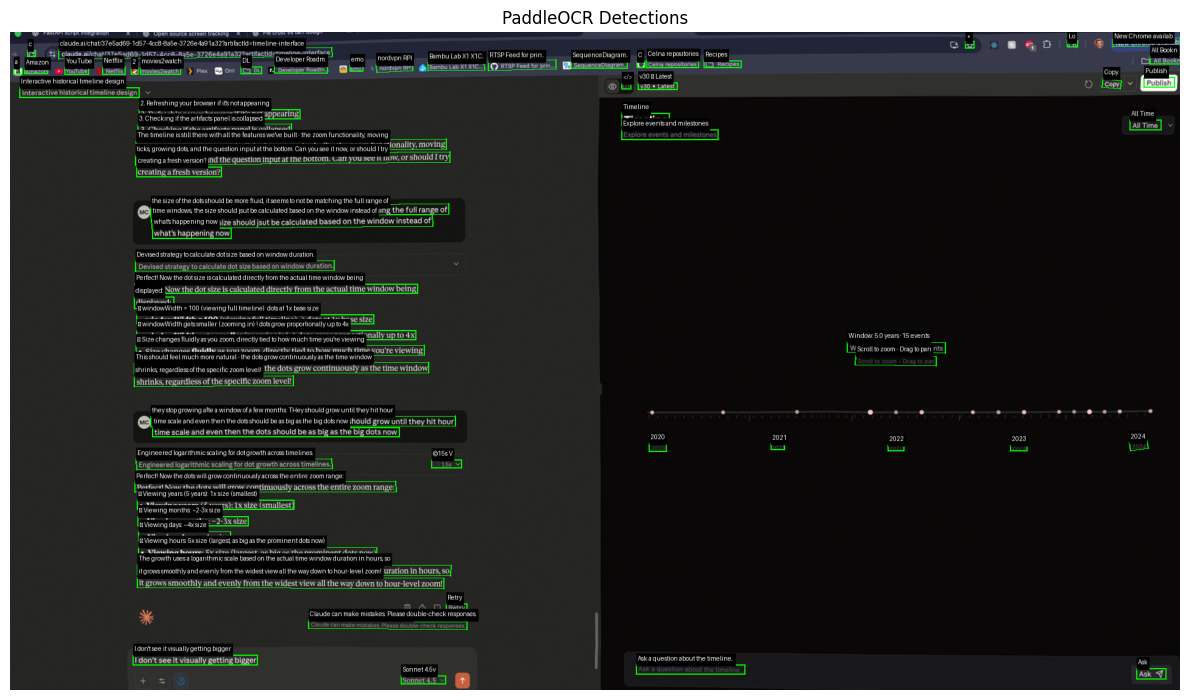

In [7]:

def log_ocr_results(ocr_result, boxes, texts, scores):
    if isinstance(ocr_result, list) and ocr_result and isinstance(ocr_result[0], Mapping):
        for batch_idx, batch in enumerate(ocr_result):
            data = batch.get("data") or []
            for entry_idx, entry in enumerate(data):
                text = entry.get("text", "")
                confidence = entry.get("confidence")
                conf_str = f"{confidence:.3f}" if isinstance(confidence, Number) else "-"
                print(f"[batch {batch_idx} item {entry_idx}] conf={conf_str} text={text!r}")
    else:
        for idx, (text, score) in enumerate(zip(texts, scores)):
            conf_str = f"{score:.3f}" if isinstance(score, Number) else "-"
            print(f"[{idx}] conf={conf_str} text={text!r}")


In [8]:
# Text logging handled by log_ocr_results(...)/


01. * (confidence: 0.68)
    Box: [[1568.0, 16.0], [1581.0, 16.0], [1581.0, 28.0], [1568.0, 28.0]]
02. Lo (confidence: 0.51)
    Box: [[1735.0, 15.0], [1751.0, 15.0], [1751.0, 26.0], [1735.0, 26.0]]
03. New Chrome availab (confidence: 0.99)
    Box: [[1810.0, 13.0], [1919.0, 10.0], [1919.0, 24.0], [1810.0, 26.0]]
04. c (confidence: 0.76)
    Box: [[29.0, 31.0], [41.0, 31.0], [41.0, 42.0], [29.0, 42.0]]
05. claude.ai/chat/37e5ad69-1d57-4cc8-8a5e-3726e4a91a32?artifactId=timeline-interface (confidence: 0.99)
    Box: [[80.0, 30.0], [527.0, 26.0], [528.0, 42.0], [80.0, 46.0]]
06. RTSP Feed for prin.. (confidence: 0.94)
    Box: [[785.0, 49.0], [895.0, 46.0], [895.0, 62.0], [785.0, 65.0]]
07. P (confidence: 0.34)
    Box: [[906.0, 50.0], [920.0, 50.0], [920.0, 61.0], [906.0, 61.0]]
08. SequenceDiagram.. (confidence: 0.98)
    Box: [[921.0, 49.0], [1012.0, 49.0], [1012.0, 61.0], [921.0, 61.0]]
09. C (confidence: 0.71)
    Box: [[1029.0, 49.0], [1041.0, 49.0], [1041.0, 60.0], [1029.0, 60.0]]


Grouped overlay saved to /Users/mattcarroll/code/memoir/logs/benchmark_output/original_2025-10-13_18-15-10-019586_grouped.png
Grouped markdown saved to /Users/mattcarroll/code/memoir/logs/benchmark_output/original_2025-10-13_18-15-10-019586_groups.md


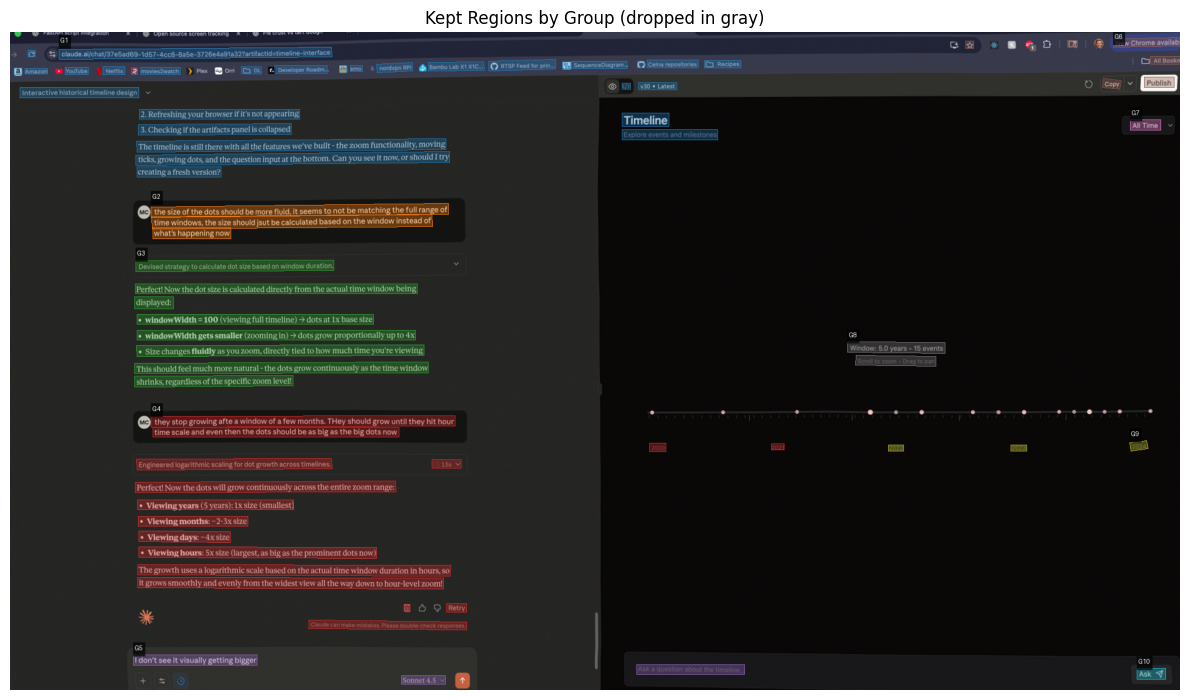

In [10]:

import numpy as np
from PIL import Image, ImageDraw, ImageFont

# --- geometry helpers ---
def _box_bounds(box):
    xs = [p[0] for p in box]
    ys = [p[1] for p in box]
    return min(xs), min(ys), max(xs), max(ys)

def _poly_height(box):
    x0, y0, x1, y1 = _box_bounds(box)
    return y1 - y0

def _x_center(box):
    x0, _, x1, _ = _box_bounds(box)
    return (x0 + x1) / 2.0

def _y_top(box):
    _, y0, _, _ = _box_bounds(box)
    return y0

# --- filter left/top chrome + edge-keywords + min conf ---
def filter_chrome(image_rgb, boxes, texts, scores, left_ratio=0.12, top_ratio=0.06, min_conf=0.65):
    H, W = image_rgb.shape[:2]
    menu_tokens = {"home", "file", "edit", "view", "help", "settings", "sign", "login", "account", "share", "about"}
    keep, drop = [], []
    for i, box in enumerate(boxes):
        if not box:
            drop.append(i)
            continue
        conf = (scores[i] if scores and i < len(scores) else None)
        if conf is not None and conf < min_conf:
            drop.append(i)
            continue
        x0, y0, x1, y1 = _box_bounds(box)
        if x1 <= left_ratio * W or y1 <= top_ratio * H:
            drop.append(i)
            continue
        text_lower = (texts[i] or "").lower()
        if any(tok in text_lower for tok in menu_tokens):
            if x0 < 0.25 * W or y0 < 0.12 * H:
                drop.append(i)
                continue
        keep.append(i)
    return keep, drop

# --- N-column detection ---
def _split_columns_dbscan(indices, boxes, W, eps_ratio=0.06, min_points=4):
    from sklearn.cluster import DBSCAN  # local import; ok if sklearn present

    xs = np.array([_x_center(boxes[i]) for i in indices], dtype=float)
    X = (xs / float(W)).reshape(-1, 1)
    db = DBSCAN(eps=eps_ratio, min_samples=max(3, min_points)).fit(X)
    labels = db.labels_
    cols = {}
    for idx, label in zip(indices, labels):
        if label == -1:
            continue
        cols.setdefault(label, []).append(idx)
    major = [c for c in cols.values() if len(c) >= min_points]
    if not major:
        return [sorted(indices, key=lambda i: _y_top(boxes[i]))]

    def _mx(col):
        return np.mean([_x_center(boxes[i]) for i in col])

    major.sort(key=_mx)
    rest = [i for i in indices if all(i not in c for c in major)]
    if rest:
        means = [_mx(c) for c in major]
        for i in rest:
            x = _x_center(boxes[i])
            j = int(np.argmin([abs(x - m) for m in means]))
            major[j].append(i)
    for col in major:
        col.sort(key=lambda i: _y_top(boxes[i]))
    return major

def _split_columns_projection(indices, boxes, W, bins=96, min_gutter_ratio=0.02, min_col_items=4):
    hist = np.zeros(bins, dtype=float)
    to_bin = lambda x: int(np.clip(np.floor(x / W * bins), 0, bins - 1))
    for i in indices:
        x0 = _box_bounds(boxes[i])[0]
        x1 = _box_bounds(boxes[i])[2]
        b0, b1 = to_bin(x0), to_bin(x1)
        hist[b0 : b1 + 1] += 1.0
    threshold = np.percentile(hist, 25)
    min_gutter = max(1, int(min_gutter_ratio * bins))
    cuts, run = [], []
    for idx, val in enumerate(hist):
        if val <= threshold:
            run.append(idx)
        else:
            if len(run) >= min_gutter:
                cuts.append((run[0], run[-1]))
            run = []
    if len(run) >= min_gutter:
        cuts.append((run[0], run[-1]))
    cut_xs = [((a + b) / 2.0 / bins) * W for a, b in cuts]
    bands, edges = [], [0.0] + cut_xs + [float(W)]
    for a, b in zip(edges[:-1], edges[1:]):
        band = [i for i in indices if a <= _x_center(boxes[i]) < b]
        if len(band) >= min_col_items:
            band.sort(key=lambda i: _y_top(boxes[i]))
            bands.append(band)
    if not bands:
        return [sorted(indices, key=lambda i: _y_top(boxes[i]))]
    return bands

def split_columns_dynamic(indices, boxes, W, eps_ratio=0.06, min_points=4):
    try:
        return _split_columns_dbscan(indices, boxes, W, eps_ratio=eps_ratio, min_points=min_points)
    except Exception:
        return _split_columns_projection(indices, boxes, W)

def group_paragraphs(col_indices, boxes, gap_factor=1.5):
    if not col_indices:
        return []
    heights = [_poly_height(boxes[i]) for i in col_indices]
    med_h = float(np.median(heights)) if heights else 16.0
    max_gap = gap_factor * med_h
    groups, cur, prev_y1 = [], [], None
    for i in col_indices:
        y0 = _box_bounds(boxes[i])[1]
        y1 = _box_bounds(boxes[i])[3]
        if prev_y1 is not None and (y0 - prev_y1) > max_gap and cur:
            groups.append(cur)
            cur = []
        cur.append(i)
        prev_y1 = y1
    if cur:
        groups.append(cur)
    return groups

def draw_grouped_regions(image_rgb, boxes, keep_groups, dropped_indices=None, font_path=None):
    pil = Image.fromarray(image_rgb.copy())
    draw = ImageDraw.Draw(pil, "RGBA")
    palette = [
        (31, 119, 180, 90),
        (255, 127, 14, 90),
        (44, 160, 44, 90),
        (214, 39, 40, 90),
        (148, 103, 189, 90),
        (140, 86, 75, 90),
        (227, 119, 194, 90),
        (127, 127, 127, 90),
        (188, 189, 34, 90),
        (23, 190, 207, 90),
    ]
    if dropped_indices:
        for i in dropped_indices:
            if not boxes[i]:
                continue
            poly = [(float(x), float(y)) for x, y in boxes[i]]
            draw.polygon(poly, outline=(180, 180, 180, 180))
    for group_idx, group in enumerate(keep_groups):
        color = palette[group_idx % len(palette)]
        outline = (color[0], color[1], color[2], 220)
        for i in group:
            poly = [(float(x), float(y)) for x, y in boxes[i]]
            draw.polygon(poly, fill=color, outline=outline)
        first = group[0]
        x0, y0, _, _ = _box_bounds(boxes[first])
        label = f"G{group_idx + 1}"
        try:
            font = ImageFont.truetype(font_path, 16) if font_path else None
        except Exception:
            font = None
        text_width = draw.textlength(label, font=font) if hasattr(draw, "textlength") else 8 * len(label)
        text_height = font.size if font else 16
        y_label = max(0, y0 - text_height - 4)
        draw.rectangle([(x0, y_label), (x0 + text_width + 6, y_label + text_height + 6)], fill=(0, 0, 0, 180))
        draw.text((x0 + 3, y_label + 3), label, fill=(255, 255, 255, 255), font=font)
    return pil

def groups_to_markdown(groups, boxes, texts):
    out = []
    for group_index, group in enumerate(groups, 1):
        out.append(f"### Group {group_index}\n")
        paragraph = " ".join([(texts[i] or "").strip() for i in group if (texts[i] or "").strip()])
        if paragraph:
            out.append(paragraph + "\n")
    return "\n".join(out).strip()

def _coerce_texts_scores(boxes, texts, scores):
    n = len(boxes)
    if texts is None:
        texts_out = [""] * n
    else:
        texts_out = list(texts)
        if len(texts_out) < n:
            texts_out += [""] * (n - len(texts_out))
        texts_out = texts_out[:n]
    if scores is None:
        scores_out = [None] * n
    elif isinstance(scores, (list, tuple)):
        scores_out = [None if s is None else float(s) for s in scores]
        if len(scores_out) < n:
            scores_out += [None] * (n - len(scores_out))
        scores_out = scores_out[:n]
    elif isinstance(scores, np.ndarray):
        flat = scores.ravel().tolist()
        scores_out = [None if s is None else float(s) for s in flat]
        if len(scores_out) < n:
            scores_out += [None] * (n - len(scores_out))
        scores_out = scores_out[:n]
    else:
        try:
            val = float(scores)
        except Exception:
            val = None
        scores_out = [val] * n
    return texts_out, scores_out

def build_grouped_overlay(image_rgb, boxes, texts, scores):
    texts_fix, scores_fix = _coerce_texts_scores(boxes, texts, scores)
    _, drop_idx = filter_chrome(image_rgb, boxes, texts_fix, scores_fix, left_ratio=0.12, top_ratio=0.06, min_conf=0.65)
    H, W = image_rgb.shape[:2]
    columns = split_columns_dynamic(list(range(len(boxes))), boxes, W, eps_ratio=0.06, min_points=4)
    groups = []
    for col in columns:
        groups.extend(group_paragraphs(col, boxes, gap_factor=1.5))
    overlay = draw_grouped_regions(image_rgb, boxes, groups, dropped_indices=drop_idx, font_path=None)
    markdown = groups_to_markdown(groups, boxes, texts_fix)
    return overlay, groups, drop_idx, markdown


In [ ]:

def process_image(image_path: Path):
    image_data = load_and_prepare_image(image_path)
    image_bgr = image_data["bgr"]
    image_rgb = image_data["rgb"]
    original_h, original_w = image_data["original_shape"]
    resized_h, resized_w = image_data["resized_shape"]
    scale = image_data["scale"]

    print(f"Original size: {original_w}x{original_h}")
    if scale < 1.0:
        print(f"Downscaled to: {resized_w}x{resized_h} (scale={scale:.3f})")
    else:
        print("No downscaling required (within limits).")

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Preprocessed Image")
    plt.tight_layout()

    ocr_result = ocr.predict(image_bgr)
    boxes, texts, scores = normalize_ocr_result(ocr_result)
    print(f"Detected {len(boxes)} text regions after normalization.")

    viz_image_rgb, used_doc_preprocessor = extract_viz_image(ocr_result, image_rgb)
    if used_doc_preprocessor:
        print("Using doc-preprocessor output for visualization to match OCR coordinates.")

    if not boxes:
        print("No OCR boxes detected; skipping visualization outputs.")
        return

    visualized = draw_ocr_min(
        viz_image_rgb, boxes, texts, scores, drop_score=0.5, font_path=None
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(visualized)
    plt.axis("off")
    plt.title("PaddleOCR Detections")
    plt.tight_layout()

    annotated_path = image_path.with_name(image_path.stem + "_annotated" + image_path.suffix)
    visualized.save(annotated_path)
    print(f"Annotated image saved to {annotated_path}")

    log_ocr_results(ocr_result, boxes, texts, scores)

    overlay, groups, dropped_indices, markdown = build_grouped_overlay(
        viz_image_rgb, boxes, texts, scores
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Kept Regions by Group (dropped in gray)")
    plt.tight_layout()

    grouped_image_path = image_path.with_name(image_path.stem + "_grouped.png")
    overlay.save(grouped_image_path)
    print(f"Grouped overlay saved to {grouped_image_path}")

    grouped_md_path = image_path.with_name(image_path.stem + "_groups.md")
    grouped_md_path.write_text(markdown, encoding="utf-8")
    print(f"Grouped markdown saved to {grouped_md_path}")
    print(f"Groups kept: {len(groups)} | Dropped detections: {len(dropped_indices)}")

for image_path in IMAGE_PATHS:
    print()
    print("=" * 80)
    print(f"Processing {image_path}")
    process_image(image_path)
